In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Basado en este dataset: 
# https://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=spiral&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4,2&seed=0.57689&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false

In [50]:
from sklearn.datasets import make_moons
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import time

In [6]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from mlp_helper import plot_boundaries_keras
from tensorflow.keras.callbacks import TensorBoard

# Dataset

In [7]:
def get_spiral_dataset(n = 100, noise=0.05, cicles = 2, seed=42):
    np.random.seed(seed)
    N = n//2
    Noise1 = np.random.normal(0, noise, (N, 2))
    Noise2 = np.random.normal(0, noise, (N, 2))
    r = np.linspace(0.1, 1, N)
    theta = np.linspace(0.1,cicles*2*np.pi, N)
    X1 = np.vstack([r*np.cos(theta), r*np.sin(theta)]).T + Noise1# *r.reshape(-1,1)
    X2 = np.vstack([-r*np.cos(theta), -r*np.sin(theta)]).T + Noise2# *r.reshape(-1,1)
    X = np.vstack([X1, X2]) 
    y = np.array([0]*N + [1]*N)
    return X, y

In [612]:
X, y = get_spiral_dataset(n=1000, seed=42)
X_test, y_test = get_spiral_dataset(n=200, seed=2)

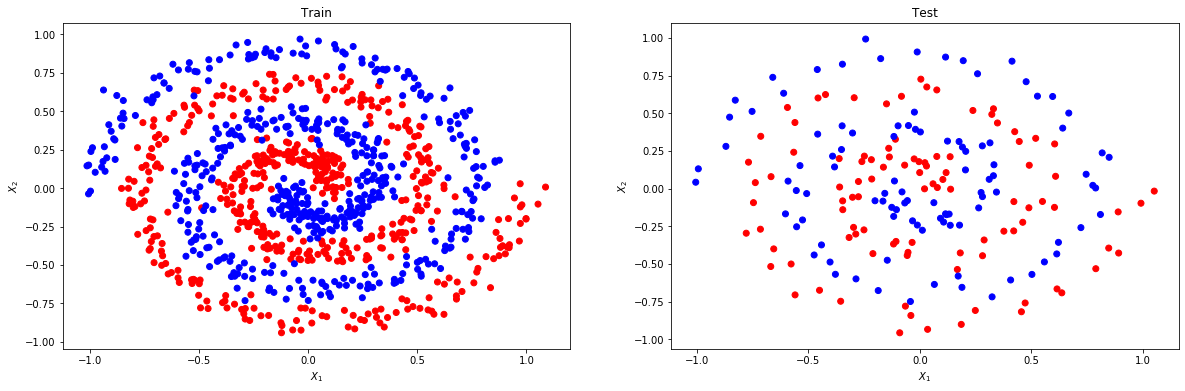

In [613]:
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
ax1.scatter(X[:,0], X[:,1], c=y, cmap=cm_bright)
ax1.set_xlabel('$X_1$')
ax1.set_ylabel('$X_2$')
ax1.set_title('Train')
ax2.scatter(X_test[:,0], X_test[:,1], c=y_test, cmap=cm_bright)
ax2.set_xlabel('$X_1$')
ax2.set_ylabel('$X_2$')
ax2.set_title('Test')
plt.show()

In [614]:
def get_sphere_coordinates(X, unwrap=False):
    r = (X[:, 0]**2 + X[:, 1]**2)**0.5
    theta = np.arctan2(X[:, 1], X[:, 0])
    if unwrap:
        theta = np.unwrap(theta)
        
    X_rad = np.vstack([r, theta]).T
    return X_rad

def get_cart_coordinates(X_sphere):
    return np.vstack([X_sphere[:,0]*np.cos(X_sphere[:,1]),
    X_sphere[:,0]*np.sin(X_sphere[:,1])]).T

In [615]:
X_sphere = get_sphere_coordinates(X)
X_sphere_test = get_sphere_coordinates(X_test)

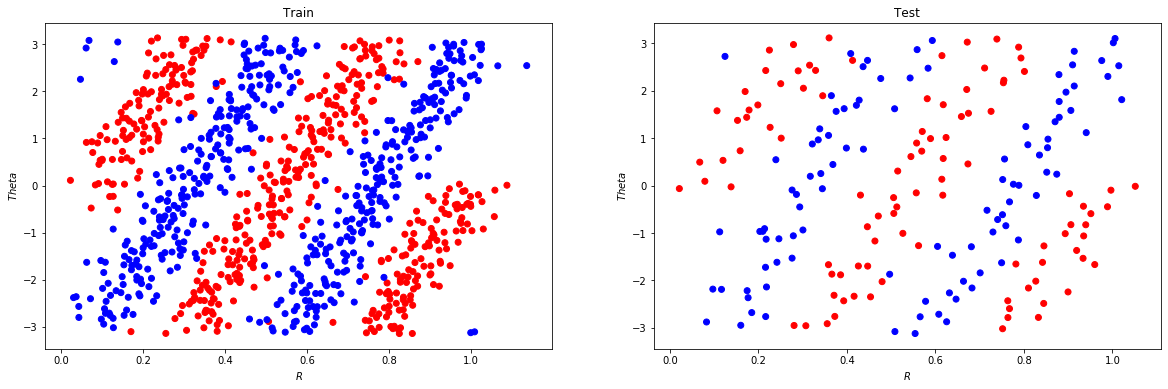

In [616]:
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
ax1.scatter(X_sphere[:,0], X_sphere[:,1], c=y, cmap=cm_bright)
ax1.set_xlabel('$R$')
ax1.set_ylabel('$Theta$')
ax1.set_title('Train')
ax2.scatter(X_sphere_test[:,0], X_sphere_test[:,1], c=y_test, cmap=cm_bright)
ax2.set_xlabel('$R$')
ax2.set_ylabel('$Theta$')
ax2.set_title('Test')
plt.show()

Text(0, 0.5, 'theta')

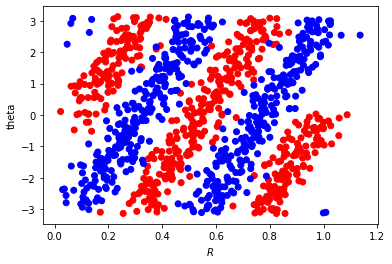

In [617]:
plt.scatter(X_sphere[:,0], X_sphere[:,1], c=y, cmap=cm_bright)
plt.xlabel('$R$')
plt.ylabel('theta')

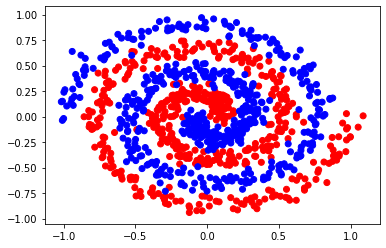

In [618]:
plt.scatter(X_sphere[:,0]*np.cos(X_sphere[:,1]), X_sphere[:,0]*np.sin(X_sphere[:,1]), c=y, cmap=cm_bright)

# Simple model Feature engineering

In [628]:
def get_simple_model(activation='sigmoid', input_dim=2, hidden_units=10, lr=0.01, compile_model=True):
    X_in = Input(shape=(input_dim,), name='Input')
    X = Dense(hidden_units, input_shape=(1,), activation=activation, name='hidden')(X_in)
    X1 = Dense(1, name='Categorical_out', activation='sigmoid')(X)
    model = Model(X_in, X1)
    if compile_model:
        losses = {'Categorical_out': 'binary_crossentropy'}
        metrics = {'Categorical_out': 'accuracy'}
        model.compile(Adam(lr=lr), loss=losses, metrics=metrics)
    return model

In [629]:
simple_model = get_simple_model(lr=0.25, hidden_units=10)
simple_model.summary()

Model: "model_62"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 2)]               0         
_________________________________________________________________
hidden (Dense)               (None, 10)                30        
_________________________________________________________________
Categorical_out (Dense)      (None, 1)                 11        
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________


In [630]:
epochs = 1000
history = simple_model.fit(X_sphere, y, verbose=0, epochs=epochs, batch_size=64)

In [631]:
def predict_proba_simple(X):
    X_rad = get_sphere_coordinates(X)
    return simple_model.predict(X_rad)

def score_func_simple(X, y):
    X_rad = get_sphere_coordinates(X)
    return simple_model.evaluate(X_rad, y, verbose=0)[1]

In [632]:
score_train = score_func_simple(X, y)
score_test = score_func_simple(X_test, y_test)
print(score_train, score_test)

0.973 0.97


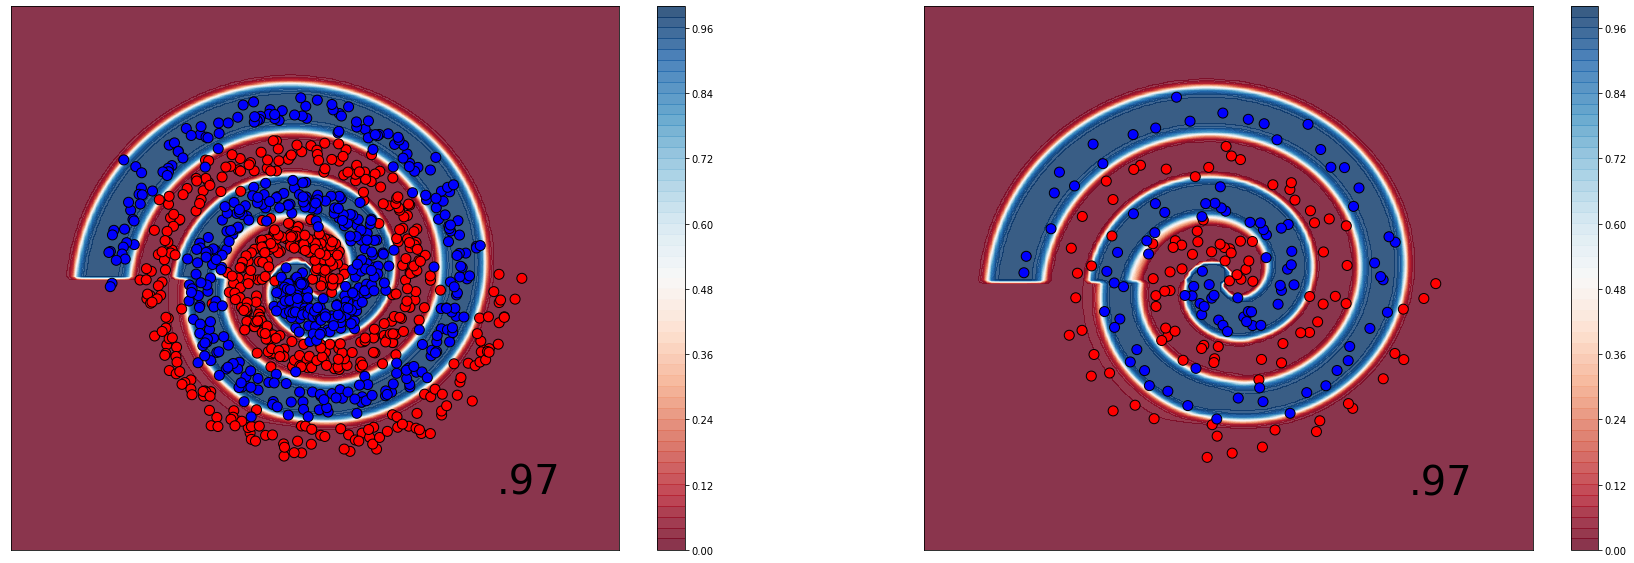

In [633]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(30,10))
plot_boundaries_keras(X, y, score_train, probability_func=predict_proba_simple, ax=ax1)
plot_boundaries_keras(X_test, y_test, score_test, probability_func=predict_proba_simple, ax=ax2)

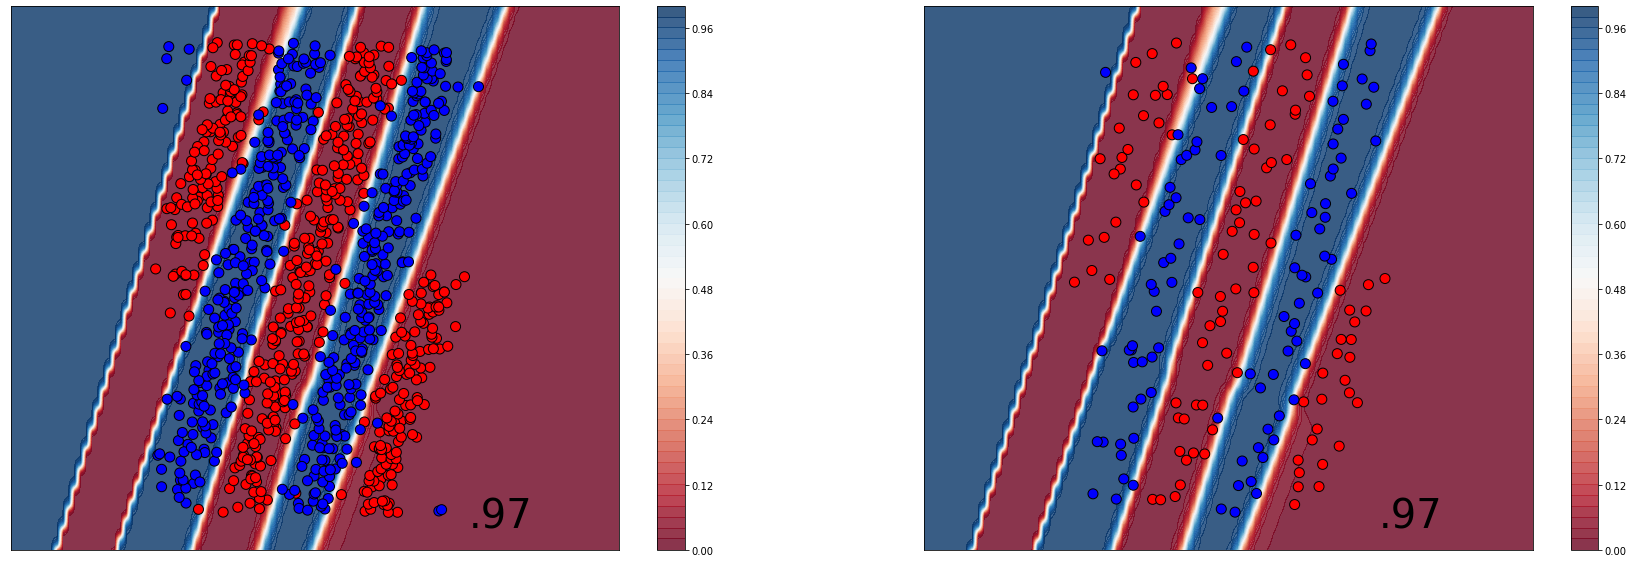

In [634]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(30,10))
plot_boundaries_keras(X_sphere, y, score_train, probability_func=simple_model.predict, ax=ax1)
plot_boundaries_keras(X_sphere_test, y_test, score_test, probability_func=simple_model.predict, ax=ax2)

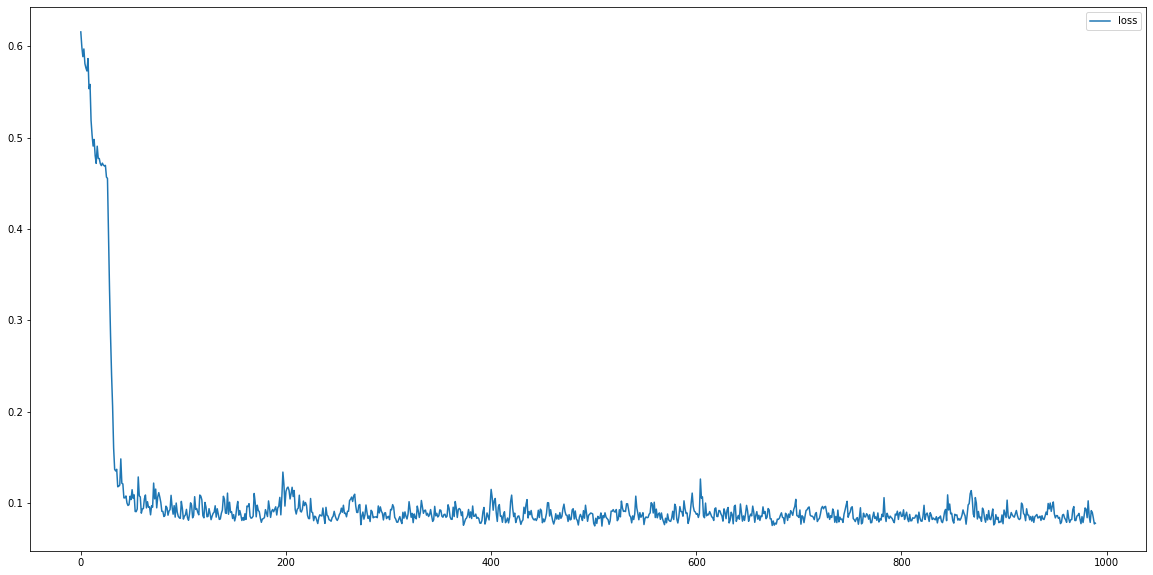

In [635]:
plt.figure(figsize=(20,10))
fr = 10
plt.plot(history.history['loss'][fr:], label='loss')
# plt.plot(model.history.history['Categorical_out_loss'][fr:], label='Categorical_out_mse')
# plt.plot(model.history.history['Linear_out_radius_loss'][fr:], label='Linear_out_radius_mse')
# plt.plot(model.history.history['Linear_out_theta_loss'][fr:], label='Linear_out_theta_mse')
plt.legend()

# No feature Engineering

In [658]:
def get_no_feat(activation='sigmoid', input_dim=2, hidden_units=[10], lr=0.01, compile_model=True):
    X_in = Input(shape=(input_dim,), name='Input')
    X = Dense(hidden_units[0], activation=activation, name=f'hidden_1')(X_in)
    for i, units in enumerate(hidden_units[1:]):
        X = Dense(units, activation=activation, name=f'hidden_{i+2}')(X)
    cat_out = Dense(1, name='Categorical_out', activation='sigmoid')(X)
    
    model = Model(X_in, cat_out)
    if compile_model:
        model.compile(Adam(lr=lr), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [670]:
model_no_feat = get_no_feat(activation='sigmoid', hidden_units=[10], lr = 0.1)
model_no_feat.summary()

Model: "model_68"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 2)]               0         
_________________________________________________________________
hidden_1 (Dense)             (None, 10)                30        
_________________________________________________________________
Categorical_out (Dense)      (None, 1)                 11        
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________


In [671]:
X, y = get_spiral_dataset(n=1000, seed=42)
X_test, y_test = get_spiral_dataset(n=200, seed=2)

In [674]:
epochs = 2000
model_no_feat.fit(X, y, verbose=0, epochs=epochs, batch_size=100, validation_data=(X_test, y_test))

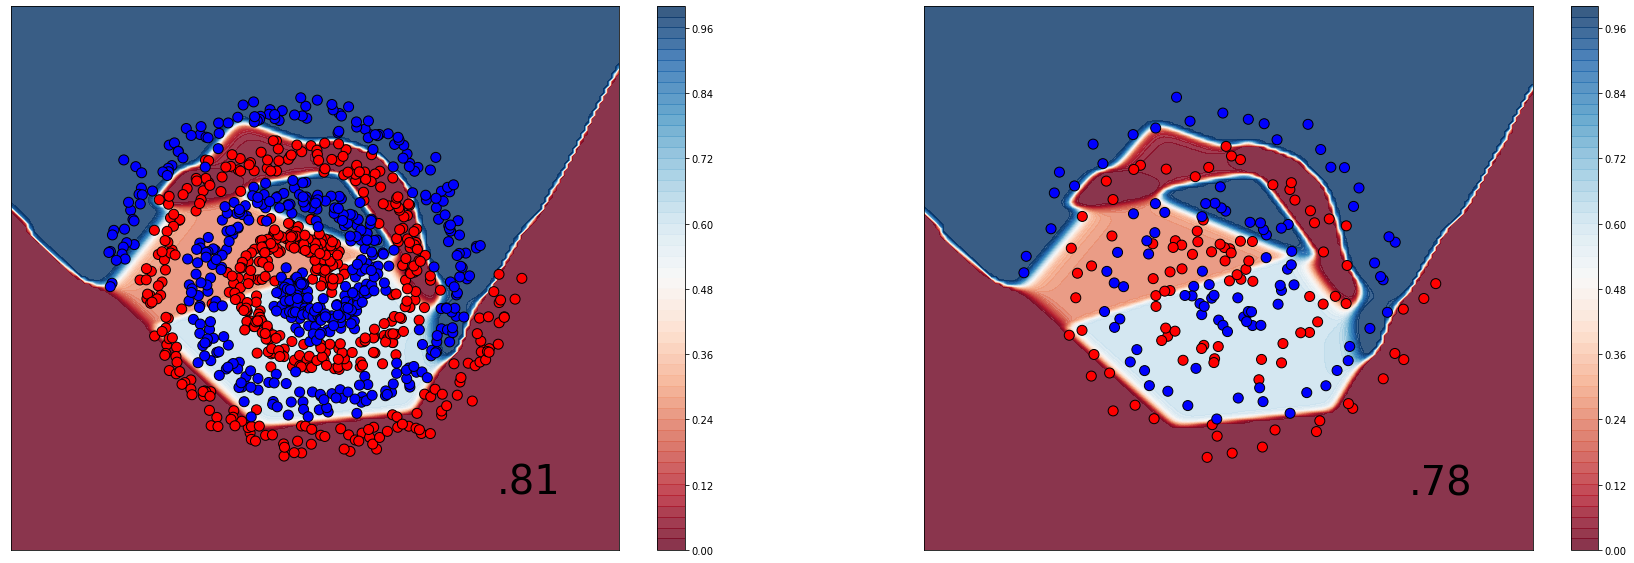

In [675]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(30,10))
score_nf_train = model_no_feat.evaluate(X, y, verbose=0)[1]
score_nf_test = model_no_feat.evaluate(X_test, y_test, verbose=0)[1]
plot_boundaries_keras(X, y, score_nf_train, probability_func=model_no_feat.predict, ax=ax1)
plot_boundaries_keras(X_test, y_test, score_nf_test, probability_func=model_no_feat.predict, ax=ax2)

In [664]:
X, y = get_spiral_dataset(n=200, seed=42)
X_test, y_test = get_spiral_dataset(n=200, seed=2)

In [665]:
model_no_feat = get_no_feat(activation='sigmoid', hidden_units=[100], lr = 0.1)


In [667]:
epochs = 2000
model_no_feat.fit(X, y, verbose=0, epochs=epochs, batch_size=100, validation_data=(X_test, y_test))

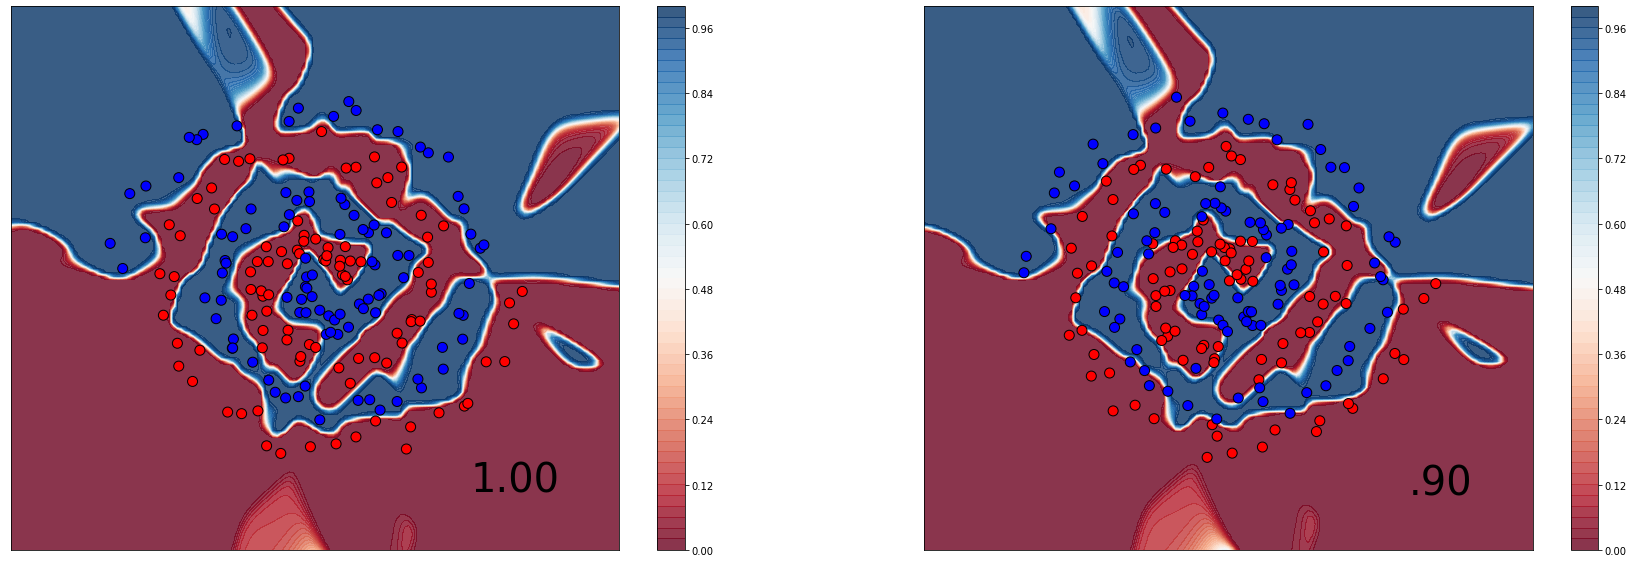

In [668]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(30,10))
score_nf_train = model_no_feat.evaluate(X, y, verbose=0)[1]
score_nf_test = model_no_feat.evaluate(X_test, y_test, verbose=0)[1]
plot_boundaries_keras(X, y, score_nf_train, probability_func=model_no_feat.predict, ax=ax1)
plot_boundaries_keras(X_test, y_test, score_nf_test, probability_func=model_no_feat.predict, ax=ax2)

# Multitask Model

In [691]:
def get_two_out_model(activation='sigmoid', input_dim=2, hidden_units=[10], lr=0.01, compile_model=True):
    X_in = Input(shape=(input_dim,), name='Input')
    X = Dense(hidden_units[0], activation=activation, name=f'hidden_1')(X_in)
    for i, units in enumerate(hidden_units[1:]):
        X = Dense(units, activation=activation, name=f'hidden_{i+2}')(X)
    cat_out = Dense(1, name='Categorical_out', activation='sigmoid')(X)
    radius = Dense(1, name='Linear_out_radius', activation='sigmoid')(X)
    theta = Dense(1, name='Linear_out_theta', activation='linear')(X)
    
    model = Model(X_in, [cat_out, radius, theta])
    if compile_model:
        losses = {'Linear_out_radius': 'mse', 'Linear_out_theta': 'mse', 'Categorical_out': 'binary_crossentropy'}
        metrics = {'Linear_out_radius': 'mse', 'Linear_out_theta': 'mse', 'Categorical_out': ['accuracy', 'mse', 'binary_crossentropy']}
        loss_weights = {'Linear_out_radius': 1,'Linear_out_theta': 1, 'Categorical_out': 1}
        model.compile(Adam(lr=lr), loss=losses, metrics=metrics, loss_weights=loss_weights)
    return model

In [692]:
model = get_two_out_model(activation='sigmoid', hidden_units=[100], lr = 0.1)
model.summary()

Model: "model_72"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 2)]          0                                            
__________________________________________________________________________________________________
hidden_1 (Dense)                (None, 100)          300         Input[0][0]                      
__________________________________________________________________________________________________
Categorical_out (Dense)         (None, 1)            101         hidden_1[0][0]                   
__________________________________________________________________________________________________
Linear_out_radius (Dense)       (None, 1)            101         hidden_1[0][0]                   
___________________________________________________________________________________________

In [693]:
X, y = get_spiral_dataset(n=1000, seed=42)
X_test, y_test = get_spiral_dataset(n=200, seed=2)

In [694]:

tensorboard_cb = TensorBoard(log_dir=f"./logs/spiral_{units}_{lr}_{int(time.perf_counter()*1000)}")
model.fit(X, [y, X_sphere[:, 0], X_sphere[:, 1]], verbose=0, 
          epochs=2000, batch_size=100, 
          validation_data=(X_test, [y_test, X_sphere_test[:, 0], X_sphere_test[:, 1]]))

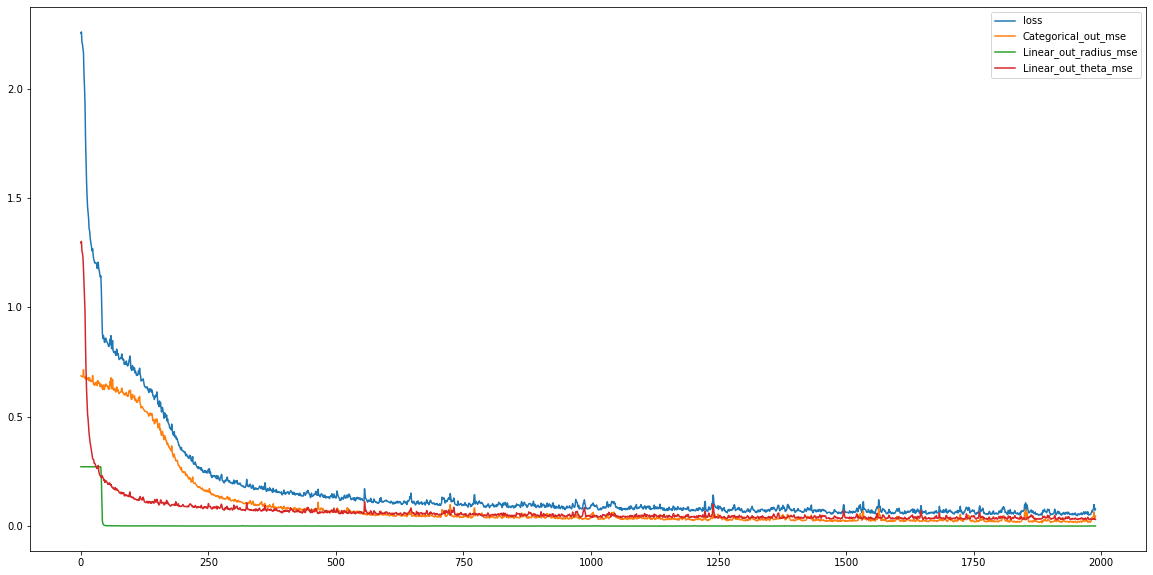

In [695]:
plt.figure(figsize=(20,10))
fr = 10
plt.plot(model.history.history['loss'][fr:], label='loss')
plt.plot(model.history.history['Categorical_out_loss'][fr:], label='Categorical_out_mse')
plt.plot(model.history.history['Linear_out_radius_loss'][fr:], label='Linear_out_radius_mse')
plt.plot(model.history.history['Linear_out_theta_loss'][fr:], label='Linear_out_theta_mse')
plt.legend()

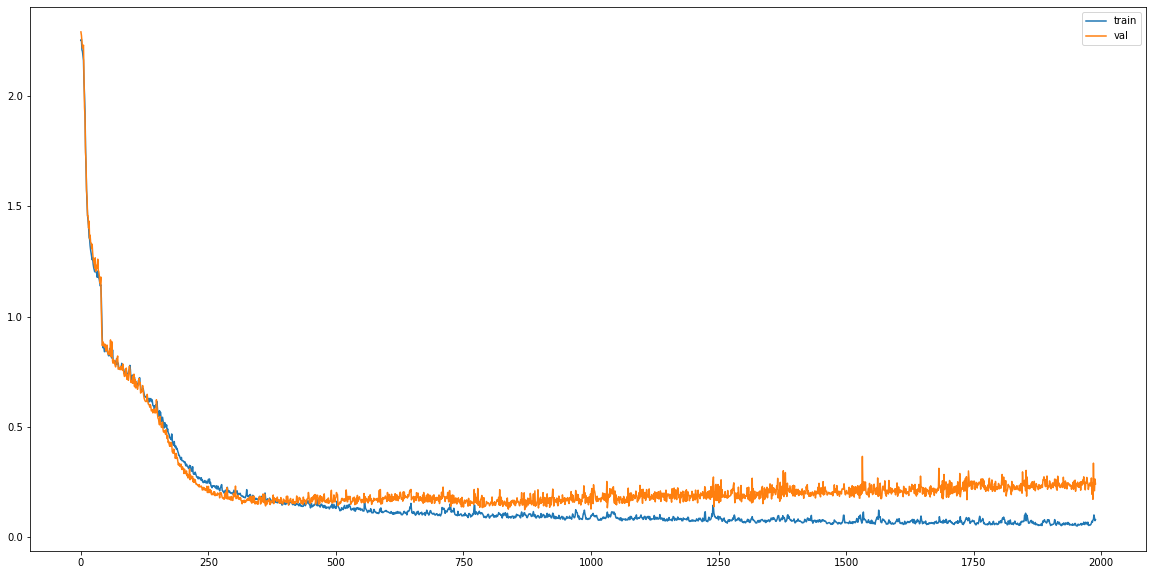

In [696]:
plt.figure(figsize=(20,10))
fr = 10
plt.plot(model.history.history['loss'][fr:], label='train')
plt.plot(model.history.history['val_loss'][fr:], label='val')
plt.legend()

In [697]:
model.history.history.keys()

dict_keys(['loss', 'Categorical_out_loss', 'Linear_out_radius_loss', 'Linear_out_theta_loss', 'Categorical_out_accuracy', 'Categorical_out_mse', 'Categorical_out_binary_crossentropy', 'Linear_out_radius_mse', 'Linear_out_theta_mse', 'val_loss', 'val_Categorical_out_loss', 'val_Linear_out_radius_loss', 'val_Linear_out_theta_loss', 'val_Categorical_out_accuracy', 'val_Categorical_out_mse', 'val_Categorical_out_binary_crossentropy', 'val_Linear_out_radius_mse', 'val_Linear_out_theta_mse'])

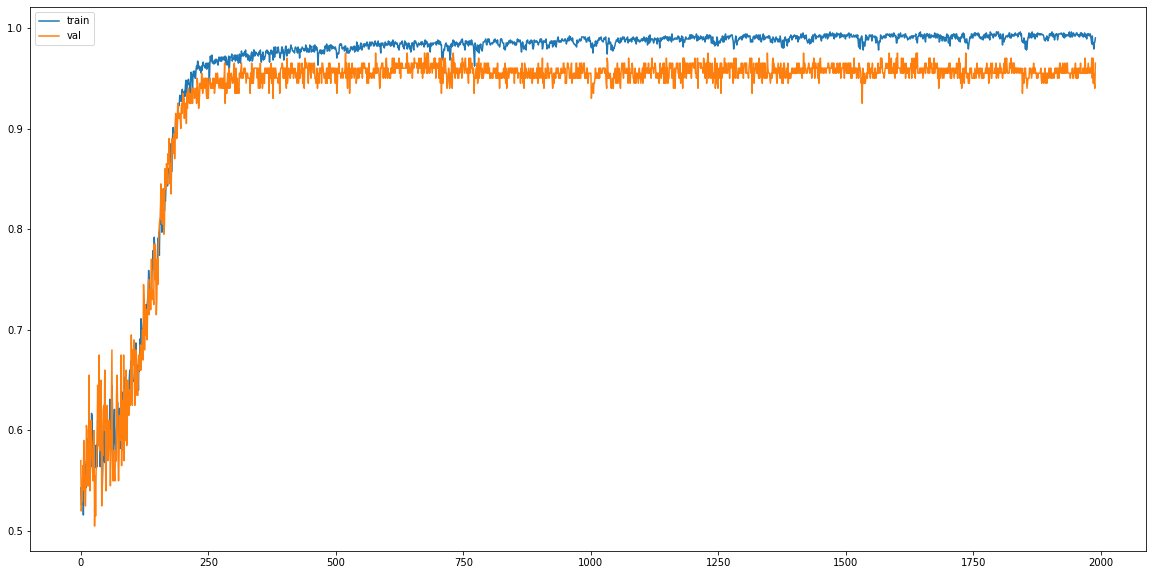

In [698]:
plt.figure(figsize=(20,10))
fr = 10
plt.plot(model.history.history['Categorical_out_accuracy'][fr:], label='train')
plt.plot(model.history.history['val_Categorical_out_accuracy'][fr:], label='val')
plt.legend()

In [705]:
print(model.metrics_names)
model.evaluate(X, [y, X_sphere[:, 0], X_sphere[:, 1]], verbose=0)

['loss', 'Categorical_out_loss', 'Linear_out_radius_loss', 'Linear_out_theta_loss', 'Categorical_out_accuracy', 'Categorical_out_mse', 'Categorical_out_binary_crossentropy', 'Linear_out_radius_mse', 'Linear_out_theta_mse']


[0.06174391935765743,
 0.028559402,
 0.00089138566,
 0.03215102,
 0.992,
 0.007166431,
 0.0292445,
 0.0009042651,
 0.031595156]

In [700]:
def predict_proba(X):
    return model.predict(X)[0]

def score_func(X, y):
    return model.evaluate(X, y, verbose=0)[4]

In [701]:
score_mt_train = score_func(X, [y, X_sphere[:, 0], X_sphere[:, 1]])
score_mt_test = score_func(X_test, [y_test, X_sphere_test[:, 0], X_sphere_test[:, 1]])

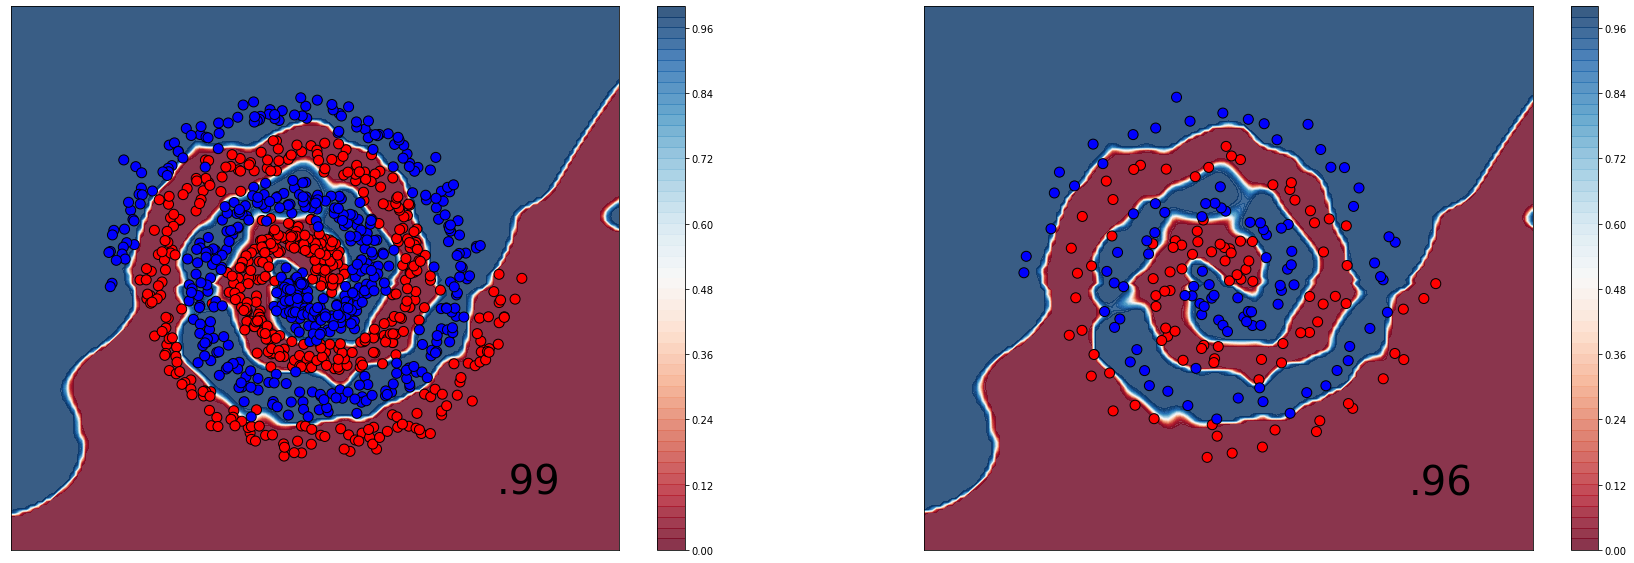

In [702]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(30,10))
plot_boundaries_keras(X, y, score_mt_train, probability_func=predict_proba, ax=ax1)
plot_boundaries_keras(X_test, y_test, score_mt_test, probability_func=predict_proba, ax=ax2)

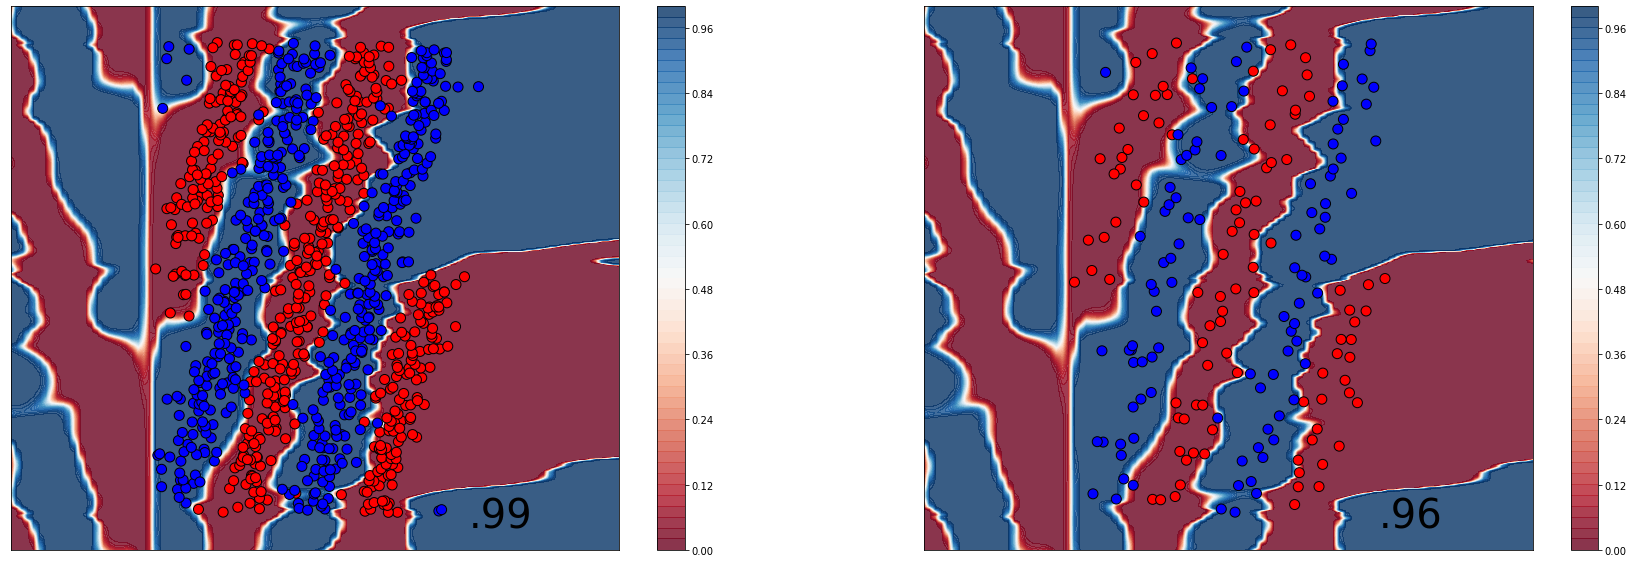

In [703]:
def predict_proba_inv(X_sphere):
    X_cart = get_cart_coordinates(X_sphere)
    return model.predict(X_cart)[0]

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(30,10))
plot_boundaries_keras(X_sphere, y, score_mt_train, probability_func=predict_proba_inv, ax=ax1)
plot_boundaries_keras(X_sphere_test, y_test, score_mt_test, probability_func=predict_proba_inv, ax=ax2)

In [353]:
y_pred, r_pred, theta_pred = model.predict(X)
y_pred_test, r_pred_test, theta_pred_test = model.predict(X_test)
y_pred = y_pred.reshape(-1)
r_pred = r_pred.reshape(-1)
theta_pred = theta_pred.reshape(-1)
y_pred_test = y_pred_test.reshape(-1)
r_pred_test = r_pred_test.reshape(-1)
theta_pred_test = theta_pred_test.reshape(-1)

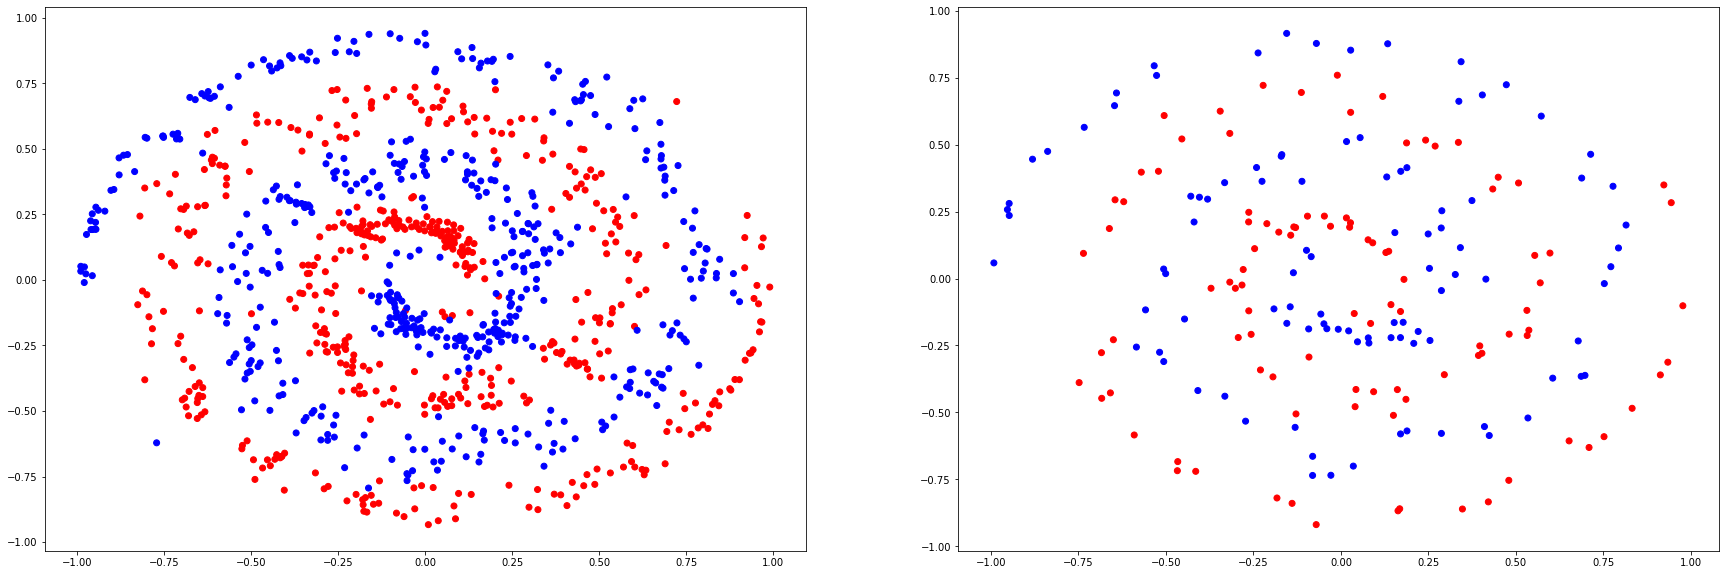

In [706]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(30,10))
#plot_boundaries_keras(X, y, None, probability_func=predict_proba_simple, plot_points=False, ax=ax1)
#plot_boundaries_keras(X, y, None, probability_func=predict_proba_simple, plot_points=False, ax=ax2)
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
ax1.scatter(r_pred*np.cos(theta_pred), r_pred*np.sin(theta_pred), c=y, 
            cmap=cm_bright)
ax2.scatter(r_pred_test*np.cos(theta_pred_test), r_pred_test*np.sin(theta_pred_test), c=y_test, 
            cmap=cm_bright)